# ADS Thesis Project - Random Forest and Boosting Models

**Authors: Marion Späth (2772981)**


This notebook documents the Random Forest and Boosting Models for both cattle and goat herders.
The datasets have been created in the R file for the Elastic Net.

### Import libraries

In [1]:
#!pip install shap
#!pip install lightgbm 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import os

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# with pickle we can save the model, helps with long computation times
import pickle

### Import datasets

In [2]:
pd.set_option('display.max_columns', None) # show all columns in output

# set working directory
os.chdir('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data')

# load train and test data (previously created in the ElasticNet notebook)
train_cattle = pd.read_csv("train_goat_df.csv")
train_goat = pd.read_csv("train_cattle_df.csv")
test_cattle = pd.read_csv("test_goat_df.csv")
test_goat = pd.read_csv("test_cattle_df.csv")
test_goat.head(2)

,afm_language,age_constant_z,agric_land,amh_language,educ_recoded_constant,eng_language,expend,irrigated_land_bin,number_minors_z,educ_child_recoded,activity_child_recoded,household_description,number_adults_z,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip,resid_mixed
0,No,-0.496108,Yes,No,Never attended,No,0,0,-0.159894,Elementary,Student,Fully settled: The whole of the household (all...,-0.213343,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,-0.597265
1,No,0.105843,Yes,No,Never attended,No,0,1,-1.389756,Never attended school,Working with Livestock,Fully settled: The whole of the household (all...,1.286942,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,0.254622


### Prepare Datasets for Models

Create dummies for categorical variables and split X and Y values for both test and train data.

In [3]:
# Prepare categorical variables but creating dummies
train_cattle = pd.get_dummies(train_cattle, drop_first='True')
train_goat = pd.get_dummies(train_goat, drop_first='True')
test_cattle = pd.get_dummies(test_cattle, drop_first='True')
test_goat = pd.get_dummies(test_goat, drop_first='True')

In [5]:
# Prepare X and Y training sets for models
X_cattle = train_cattle.copy
X_cattle = train_cattle.drop("resid_mixed", axis=1)
X_goat = train_goat.copy
X_goat = train_goat.drop("resid_mixed", axis=1)

Y_cattle = train_cattle["resid_mixed"]
Y_goat = train_goat["resid_mixed"]

# Prepare X and Y training sets for models
X_cattle_TEST = test_cattle.copy
X_cattle_TEST = test_cattle.drop(["resid_mixed", "pred", "residual"], axis=1)

Y_cattle_TEST = test_cattle["resid_mixed"]

# Random Forest

#### Set Up Hyperparameters and Performance Indicators

Prepare cross-validation using grid search including all available hyperparameters and specifying performance metrics to incluede the (negative) mean squared error, (negative) mean absolute error, and R Squared. Sklearn calculate the negative values so that the interpretation of "the higher the better" is valid across all performance metrics.

In [6]:
rf = RandomForestRegressor(random_state=0)

cv_params = {'max_depth': [5,7,10,15, None], 
             'min_samples_leaf': [2,4,6,10],
             'min_samples_split': [2,3,4,10],
             'max_features': [2,5,10,15],
             'n_estimators': [75, 100, 125, 150]
             }  

scoring = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=10, refit='neg_mean_absolute_error')

#### Fit Model

Fit the model. Runtime is ~1hour.

In [ ]:
%%time

#rf_cv.fit(X_cattle, Y_cattle)

CPU times: total: 56min 20s
Wall time: 56min 30s


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [5, 7, 10, 15, None],
                         'max_features': [2, 5, 10, 15],
                         'min_samples_leaf': [2, 4, 6, 10],
                         'min_samples_split': [2, 3, 4, 10],
                         'n_estimators': [75, 100, 125, 150]},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_squared_error', 'r2',
                      'neg_mean_absolute_error'])

#### Save the model

Model then does not need to be re-run, but can just be imported.

In [ ]:
# Pickle the model
#with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'rf_cv_model_CATTLE.pickle', 'wb') as to_write:
#    pickle.dump(rf_cv, to_write)


Read in model.

In [7]:
# Read in pickled model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/' + 'rf_cv_model_CATTLE.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

Extract best hyperparameter specifications and best model performance.

In [8]:
print("Best hyperparameters:\n", rf_cv.best_params_ , "\n")
print("Performance based on best hyperparameter specification:\n", rf_cv.best_score_)

Best hyperparameters:
 {'max_depth': 7, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150} 

Performance based on best hyperparameter specification:
 -1.063051275254341


### Refit Model Based on Best Model

In [9]:
# Fit the best model on the train set
best_model = rf_cv.best_estimator_
best_model.fit(X_cattle, Y_cattle)

X_cattle_TEST.columns = X_cattle_TEST.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

### Make Predictions on Test Set

In [148]:
# 3. Predict on the test set
y_pred = best_model.predict(X_cattle_TEST)

In [152]:
# 4. Evaluate performance
mae = mean_absolute_error(Y_cattle_TEST, y_pred)
mse = mean_squared_error(Y_cattle_TEST, y_pred)
r2  = r2_score(Y_cattle_TEST, y_pred)

print(f"Test Set Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE):  {np.sqrt(mse):.4f}")
print(f"R-squared (R²):            {r2:.4f}")

Test Set Performance:
Mean Absolute Error (MAE): 1.0470
Root Mean Squared Error (RMSE):  1.3892
R-squared (R²):            0.0039


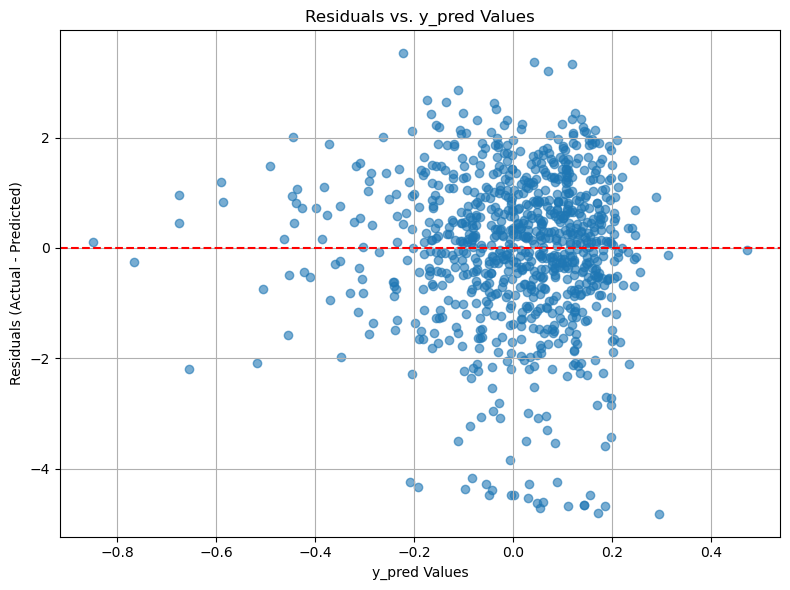

In [155]:
# Residuals = actual - predicted
residuals_rf_cattle = Y_cattle_TEST - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals_rf_cattle, alpha=0.6) #Y_cattle_TEST
plt.axhline(y=0, color='red', linestyle='--')

plt.xlabel("y_pred Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. y_pred Values")
plt.grid(True)
plt.tight_layout()
plt.show()


In [160]:
Y_cattle.max()

3.96942701120875

### Extract (Built-In) Feature Importance Scores

In [11]:
# Get feature importances from the best model
importances = rf_cv.best_estimator_.feature_importances_

# Pair them with feature names and sort by importance
feature_names = X_cattle.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                                              Feature  Importance
0                                      age_constant_z    0.138766
3                                     number_minors_z    0.112724
4                                     number_adults_z    0.074352
33                                      trust_vip_Yes    0.042988
28                                household_moved_Yes    0.041106
31  why_not_purchase_recoded_Lack of Awareness or ...    0.039918
22  household_description_Not settled: The whole h...    0.039795
25  main_info_source_recoded_Professional and Orga...    0.035919
1                                              expend    0.029956
24  main_info_source_recoded_Media, Community-Base...    0.027770
5                                          owns_phone    0.027604
7                                      agric_land_Yes    0.024842
14           educ_child_recoded_Never attended school    0.024451
6                                    afm_language_Yes    0.023818
23  househ

## Shap

### Investigate Partial Dependences and Interactions

c:\anaconda_custom\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


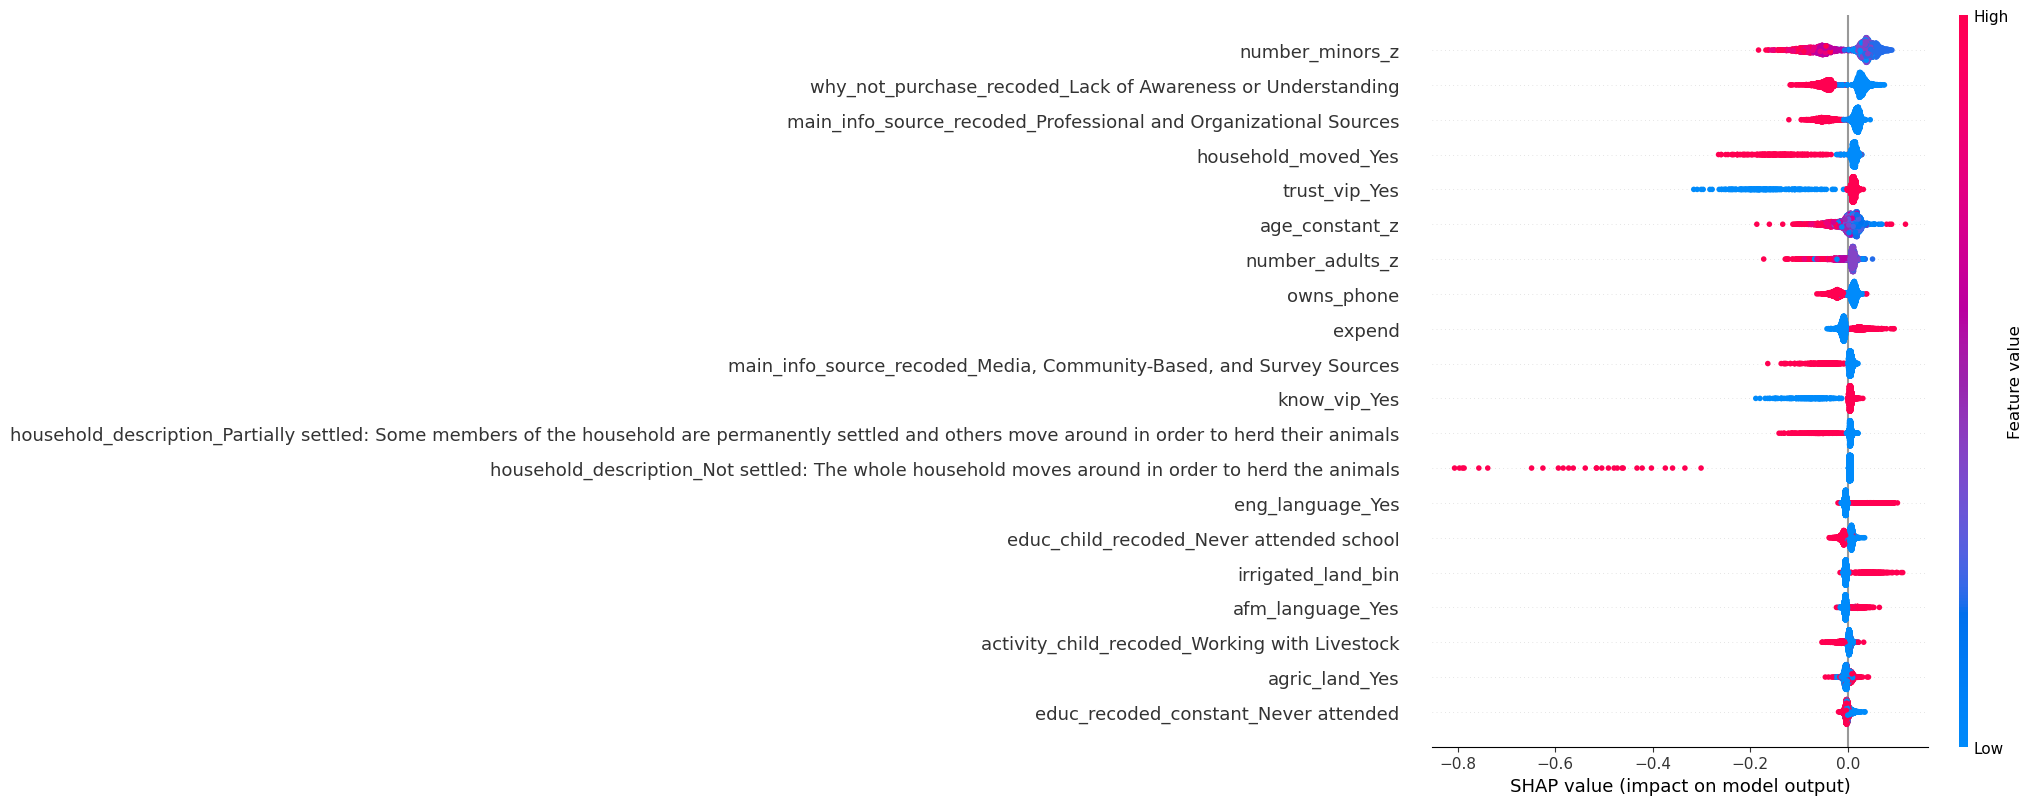

In [14]:
# Plot SHAP summary
shap.summary_plot(
    shap_values,
    X_cattle,
    plot_type="dot",
)